# Building CNN using pytorch

In [ ]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import FashionMNIST

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

Applies Seaborn’s default theme and higher DPI for sharper plots, then defines get_mnist_loader(...) which downloads FashionMNIST, randomly subsamples the training/test sets to the requested sizes, wraps them in DataLoaders using SubsetRandomSampler with the given batch_size, and returns the train and test loaders.

In [2]:
# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300


def get_mnist_loader(batch_size=100, num_train_samples = 50000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = FashionMNIST(root='data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = FashionMNIST(root='data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

Defines a Fashion-MNIST classifier: five Conv-BN-ReLU blocks that downsample by stride (28→14→7→4→2→1) while increasing channels 32→64→128→256→512, then the 1×1×512 tensor is flattened and passed through two ReLU-activated linear layers (256, 128) and a final linear layer to produce 10-class logits (use with CrossEntropyLoss; apply softmax only for probabilities at inference).

In [19]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=32, # convolution channels
                            kernel_size=3, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(32), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64,128,3,2,1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128,256,2,2,0),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(256,512,2,2,0),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU()
        )
        # set fully connected layer
        self.mlp1 = torch.nn.Linear(512*1*1,256) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(256,128)
        self.mlp3 = torch.nn.Linear(128, 10) 

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # flatten tensor to 1-D
        x = F.relu(self.mlp1(x.view(x.size(0),-1)))
        x = F.relu(self.mlp2(x))
        x = self.mlp3(x)
        return x

Trains the model on GPU if available using CrossEntropyLoss and Adam(lr=1e-3, weight_decay=5e-4): for each epoch it iterates over training batches (forward → compute loss → zero_grad() → backward() → step()), periodically prints loss and saves a checkpoint, then switches to eval with no_grad() to compute and record test accuracy, printing it each epoch and returning the list of accuracies.

In [4]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001,  weight_decay=5e-4)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

In [20]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# Define model
model = CNNnet()

In [21]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
CNNnet                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       18,496
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       73,856
│    └─BatchNorm2d: 2-8                  256
│    └─ReLU: 2-9                         --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      131,328
│    └─BatchNorm2d: 2-11                 512
│    └─ReLU: 2-12                        --
├─Sequential: 1-5                        --
│    └─Conv2d: 2-13                      524,800
│    └─BatchNorm2d: 2-14                 1,024
│    └─ReLU: 2-15                        --
├─

In [ ]:
# where to save the model
model_save = '/your_path'

import os
if not os.path.exists('/your_path'):
    os.mkdir('/your_path')
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.317274 Batch 0/500 
Training Loss:0.708468 Batch 20/500 
Training Loss:0.638575 Batch 40/500 
Training Loss:0.499875 Batch 60/500 
Training Loss:0.467763 Batch 80/500 
Training Loss:0.426434 Batch 100/500 
Training Loss:0.317323 Batch 120/500 
Training Loss:0.448347 Batch 140/500 
Training Loss:0.307607 Batch 160/500 
Training Loss:0.393259 Batch 180/500 
Training Loss:0.361232 Batch 200/500 
Training Loss:0.516653 Batch 220/500 
Training Loss:0.446422 Batch 240/500 
Training Loss:0.339092 Batch 260/500 
Training Loss:0.302383 Batch 280/500 
Training Loss:0.384921 Batch 300/500 
Training Loss:0.415376 Batch 320/500 
Training Loss:0.269497 Batch 340/500 
Training Loss:0.272041 Batch 360/500 
Training Loss:0.356672 Batch 380/500 
Training Loss:0.355384 Batch 400/500 
Training Loss:0.322585 Batch 420/500 
Training Loss:0.349667 Batch 440/500 
Training Loss:0.254843 Batch 460/500 
Training Loss:0.273478 Batch 480/500 
Epoch 0, Test Accuracy 87.050 %
Training Loss:0.341443 B

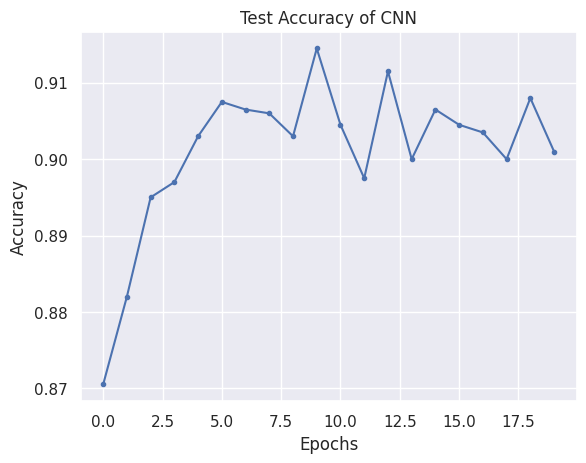

In [23]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

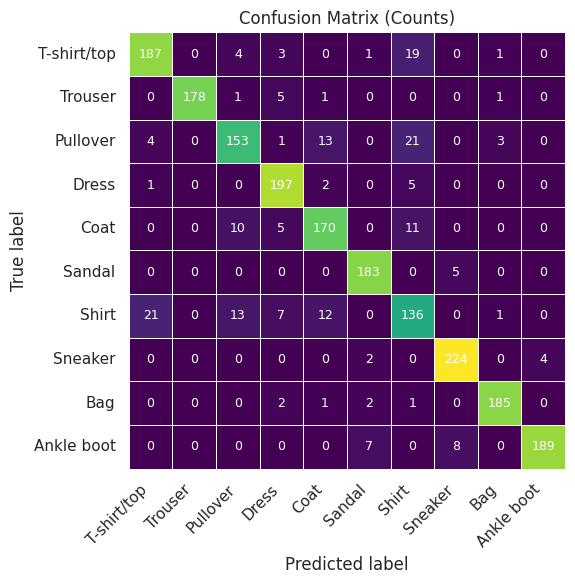

              precision    recall  f1-score   support

 T-shirt/top     0.8779    0.8698    0.8738       215
     Trouser     1.0000    0.9570    0.9780       186
    Pullover     0.8453    0.7846    0.8138       195
       Dress     0.8955    0.9610    0.9271       205
        Coat     0.8543    0.8673    0.8608       196
      Sandal     0.9385    0.9734    0.9556       188
       Shirt     0.7047    0.7158    0.7102       190
     Sneaker     0.9451    0.9739    0.9593       230
         Bag     0.9686    0.9686    0.9686       191
  Ankle boot     0.9793    0.9265    0.9521       204

    accuracy                         0.9010      2000
   macro avg     0.9009    0.8998    0.8999      2000
weighted avg     0.9015    0.9010    0.9009      2000



In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# If you're using Fashion-MNIST:
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
# For MNIST digits instead, use:
# class_names = [str(i) for i in range(10)]

device = next(model.parameters()).device
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        y_true.append(yb.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# y_true, y_pred, class_names already defined
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis', cbar=False,
    xticklabels=class_names, yticklabels=class_names,
    square=True, linewidths=.5, linecolor='white',
    annot_kws={"fontsize":9, "color":"white"}   # numbers inside the boxes
)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted label"); plt.ylabel("True label")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


# 3) Classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
